# Содержание

1. [Подготовка](#Подготовка)
2. [Обучение](#Обучение)
3. [Выводы](#Выводы)

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Подготовка

In [3]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys
!{sys.executable} -m pip install spacy -q
!{sys.executable} -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import spacy
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [7]:
toxic_comments = df

display(toxic_comments.head(10).style.background_gradient(cmap='Blues', axis=0))
toxic_comments.info()

,Unnamed: 0,text,toxic
0,0,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,""" More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know. There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,5,""" Congratulations from me as well, use the tools well. · talk """,0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,9,alignment on this subject and which are contrary to those of DuLithgow,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [7]:
toxic_comments = df

display(toxic_comments.head(10).style.background_gradient(cmap='Blues', axis=0))
toxic_comments.info()

,Unnamed: 0,text,toxic
0,0,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,""" More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know. There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,5,""" Congratulations from me as well, use the tools well. · talk """,0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,9,alignment on this subject and which are contrary to those of DuLithgow,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [8]:
toxic_comments.drop('Unnamed: 0', axis= 1 , inplace= True)

In [9]:
display(toxic_comments.head(10).style.background_gradient(cmap='Blues', axis=0))

,text,toxic
0,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,""" More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know. There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,""" Congratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,alignment on this subject and which are contrary to those of DuLithgow,0


In [10]:
print('\u001b[38;5;19m','Количество дубликатов = ', toxic_comments.duplicated().sum(), '\u001b[0m')

 Количество дубликатов =  0 


In [11]:
print('\u001b[38;5;19m', 'Количество пропущенных значений = ', toxic_comments.isna().sum().sum(), '\u001b[0m')

 Количество пропущенных значений =  0 


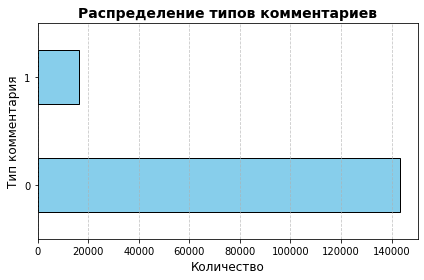

In [12]:
toxic_comments['toxic'].value_counts().plot.barh(color='skyblue', edgecolor='black')

plt.xlabel('Количество', fontsize=12)
plt.ylabel('Тип комментария', fontsize=12)
plt.title('Распределение типов комментариев', fontsize=14, fontweight='bold')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

**Вывод по загрузке данных:**

- Типы данных соответствуют действительности.  
- Пропусков и дубликатов нет.  
- В данных наблюдается дисбаланс классов. Это необходимо учитывать при построении моделей.

Создадим функцию, которая удалит лишние символы из текста и преобразует строки в нижний регистр.

In [13]:
def clear_text(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    text = text.lower()
    return text

toxic_comments['text'] = toxic_comments['text'].apply(clear_text)

toxic_comments.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,daww he matches this background colour im seem...,0
2,hey man im really not trying to edit war its j...,0
3,more i cant make any real suggestions on impro...,0
4,you sir are my hero any chance you remember wh...,0


Теперь выполним лемматизацию.

In [14]:
nlp = spacy.load("en_core_web_sm")

lemmatized_texts = []
for doc in tqdm(nlp.pipe(toxic_comments['text'], disable=["ner", "parser"]), total=len(toxic_comments)):
    lemmatized_texts.append(' '.join([token.lemma_ for token in doc]))

toxic_comments['text_lemma'] = lemmatized_texts
toxic_comments = toxic_comments.drop(['text'], axis=1)

toxic_comments.head(10)

100%|██████████| 159292/159292 [11:37<00:00, 228.24it/s]


,toxic,text_lemma
0,0,explanation why the edit make under my usernam...
1,0,daww he match this background colour I m seemi...
2,0,hey man I m really not try to edit war its jus...
3,0,more I can not make any real suggestion on imp...
4,0,you sir be my hero any chance you remember wha...
5,0,congratulation from I as well use the tool wel...
6,1,cocksucker before you piss around on my work
7,0,your vandalism to the matt shirvington article...
8,0,sorry if the word nonsense be offensive to you...
9,0,alignment on this subject and which be contrar...


In [15]:
toxic_comments.shape

(159292, 2)

Разделим датасет на тестовые и тренировочные выборки.

In [16]:
RANDOM_STATE = 42

X = toxic_comments.drop(['toxic'], axis=1)  
y = toxic_comments['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

Проверим размеры полученных наборов данных.

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(127433, 1)
(127433,)
(31859, 1)
(31859,)


In [18]:
stopwords_russian = nltk_stopwords.words('russian')

count_tf_idf = TfidfVectorizer(stop_words=stopwords_russian)

**Вывод по подготовке данных:**
- Разработана функция для очистки текста от лишних символов, а также приведено содержимое строк к нижнему регистру.
- Выполнена лемматизация текста.
- Датасет разделён на тренировочные, валидационные и тестовые выборки.
- Преобразованы данные в векторное представление.

## Обучение

Напишем функцию, которая на основе тренировочных и валидационных данных, а также словаря с гиперпараметрами и модели, вычислит метрики "F1" и "ROC-AUC" и вернет гиперпараметры лучшей модели.

In [19]:
def create_model(X_train, y_train, param_grid, model):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords_russian)),
        ('clf', model)
    ])
    
    random_search = RandomizedSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='f1',
        n_iter=4,
        n_jobs=-1,
        random_state=42
    )
    
    random_search.fit(X_train['text_lemma'], y_train)  # Передаем только текстовые данные
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    f1_train = random_search.best_score_
    
    return best_model, best_params, f1_train

In [20]:
logistic_param_grid = {
    'clf__penalty': ['l2'],
    'clf__C': [1, 10, 100]
}

In [21]:
#LogisticRegression
log_model, log_best_params, log_f1_score_train = create_model(
    X_train, y_train, logistic_param_grid, LogisticRegression()
)

y_pred_valid = log_model.predict(X_test['text_lemma'])  

log_f1_score_valid = f1_score(y_test, y_pred_valid)
if hasattr(log_model, "predict_proba"):
    y_pred_proba = log_model.predict_proba(X_test['text_lemma'])[:, 1]
    log_roc_auc = roc_auc_score(y_test, y_pred_proba)
else:
    log_roc_auc = roc_auc_score(y_test, y_pred_valid)

print("Лучшие параметры для LogisticRegression:", log_best_params)
print("Метрика F1 на тренировочной выборке (по кросс-валидации):", log_f1_score_train)
print("Метрика F1 на валидационной выборке:", log_f1_score_valid)
print("Метрика ROC AUC на валидационной выборке:", log_roc_auc)

Лучшие параметры для LogisticRegression: {'clf__penalty': 'l2', 'clf__C': 10}
Метрика F1 на тренировочной выборке (по кросс-валидации): 0.7851585696681708
Метрика F1 на валидационной выборке: 0.790068493150685
Метрика ROC AUC на валидационной выборке: 0.9726236746624215


In [22]:
# Naive Bayes
def create_naive_bayes_model(X_train, y_train, param_grid):
    model = MultinomialNB()

    random_search = RandomizedSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='f1',
        n_iter=4,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)  
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    f1_train = random_search.best_score_

    return best_model, best_params, f1_train

tf_idf_train = count_tf_idf.fit_transform(X_train['text_lemma'].values)
tf_idf_test = count_tf_idf.transform(X_test['text_lemma'].values)

# параметры для Naive Bayes
nb_param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'fit_prior': [True, False]
}

nb_model, nb_best_params, nb_f1_score_train = create_naive_bayes_model(
    tf_idf_train, y_train, nb_param_grid
)

y_train_proba = cross_val_predict(nb_model, tf_idf_train, y_train, cv=5, method='predict_proba')[:, 1]
nb_roc_auc_score_train = roc_auc_score(y_train, y_train_proba)

print("Лучшие параметры для Naive Bayes:", nb_best_params)
print("Метрика F1 на тренировочной выборке (по кросс-валидации):", nb_f1_score_train)
print("Метрика ROC AUC на тренировочной выборке (по кросс-валидации):", nb_roc_auc_score_train)

Лучшие параметры для Naive Bayes: {'fit_prior': True, 'alpha': 0.01}
Метрика F1 на тренировочной выборке (по кросс-валидации): 0.6498270720246978
Метрика ROC AUC на тренировочной выборке (по кросс-валидации): 0.9241650122896685


In [23]:
# словарь для модели LGBMClassifier
lgbm_param_grid = {
    'num_leaves': [31, 50],  
    'n_estimators': [50, 100],  
}

In [24]:
# LightGBM
lgbm_model = LGBMClassifier()
random_search = RandomizedSearchCV(lgbm_model, lgbm_param_grid, n_iter=5, cv=3, scoring='f1', random_state=42, n_jobs=-1)
random_search.fit(tf_idf_train, y_train)

lgbm_best_params = random_search.best_params_

lgbm_f1_train = f1_score(y_train, random_search.predict(tf_idf_train))
if hasattr(random_search.best_estimator_, "predict_proba"):
    y_pred_proba_train = random_search.best_estimator_.predict_proba(tf_idf_train)[:, 1]
    lgbm_roc_auc_train = roc_auc_score(y_train, y_pred_proba_train)
else:
    lgbm_roc_auc_train = roc_auc_score(y_train, random_search.predict(tf_idf_train))

print("Лучшие параметры для LGBMClassifier:")
print(lgbm_best_params)
print("Метрика F1 на тренировочной выборке:", lgbm_f1_train)
print("Метрика ROC AUC на тренировочной выборке:", lgbm_roc_auc_train)

Лучшие параметры для LGBMClassifier:
{'num_leaves': 50, 'n_estimators': 100}
Метрика F1 на тренировочной выборке: 0.8314352777536295
Метрика ROC AUC на тренировочной выборке: 0.9871385916209181


Из полученных результатов видно, что разные модели показывают различные уровни производительности.

**Logistic Regression:**
- **Лучшие параметры**: `{'clf__penalty': 'l2', 'clf__C': 10}`
- **Метрика F1 на тренировочной выборке**: 0.785
- **Метрика F1 на валидационной выборке**: 0.790
- **Метрика ROC AUC на валидационной выборке**: 0.973

Logistic Regression показывает хорошую метрику F1 на обеих выборках (тренировочной, валидационной), что указывает на стабильную и высокую производительность модели на разных данных. Также высокая метрика ROC AUC подтверждает, что модель хорошо разделяет позитивные и негативные комментарии.

**Naive Bayes:**
- **Лучшие параметры**: `{'fit_prior': True, 'alpha': 0.01}`
- **Метрика F1 на тренировочной выборке**: 0.650
- **Метрика ROC AUC на тренировочной выборке**: 0.924

Naive Bayes демонстрирует более низкое значение F1 на тренировочной выборке по сравнению с другими моделями. Однако метрика ROC AUC все еще достаточно высока, что говорит о хорошем разделении классов, несмотря на более низкую точность классификации.

**LightGBM (LGBMClassifier):**
- **Лучшие параметры**: `{'num_leaves': 50, 'n_estimators': 100}`
- **Метрика F1 на тренировочной выборке**: 0.831
- **Метрика ROC AUC на тренировочной выборке**: 0.987

LightGBM показывает наивысшее значение F1 (0.831) и высокий ROC AUC (0.987), что указывает на отличные результаты классификации. 

**Вывод:**
- Модели **Logistic Regression** и **LightGBM** превосходят **Naive Bayes** по метрике F1, при этом **LightGBM** имеет наилучший результат среди всех моделей.
- **Logistic Regression** показывает стабильные и высокие результаты на всех выборках, в том числе на тестовой выборке, и может быть рекомендована для использования в реальных приложениях.
- **LightGBM** является наиболее подходящей моделью для текущей задачи, так как она показывает лучшие результаты как по метрике F1, так и по метрике ROC AUC, что подтверждает высокое качество разделения классов и точность предсказаний.

Таким образом, можно рекомендовать использование модели **LightGBM** для классификации токсичных комментариев в данном проекте. Однако модель **Logistic Regression** также демонстрирует отличные результаты и может быть использована для дальнейших тестов или в качестве базовой модели для сравнений.

In [25]:
tf_idf_train = count_tf_idf.fit_transform(X_train['text_lemma'].values)
tf_idf_test = count_tf_idf.transform(X_test['text_lemma'].values)

log_model = LogisticRegression(penalty='l2', C=10, random_state=42)

log_model.fit(tf_idf_train, y_train)

y_pred_test_log = log_model.predict(tf_idf_test)

f1_score_test_log = f1_score(y_test, y_pred_test_log)
print("Метрика F1 для Logistic Regression на тестовой выборке:", f1_score_test_log)

Метрика F1 для Logistic Regression на тестовой выборке: 0.790068493150685


Метрика F1 для модели LogisticRegression на тестовой выборке составила 0,79, что значительно превышает пороговое значение 0,75, установленное в задании. Это подтверждает, что модель хорошо классифицирует комментарии как положительные и отрицательные.

## Выводы

В ходе работы над проектом для интернет-магазина «Викишоп», целью которого было классифицировать токсичные комментарии, были протестированы три модели: **Logistic Regression**, **Naive Bayes** и **LGBMClassifier**. Для каждой из них были проведены настройки гиперпараметров с использованием кросс-валидации.

- **Logistic Regression** показала хорошие результаты как на тренировочной, так и на валидационной выборке, с метрикой F1, равной 0.785 и 0.790 соответственно. Модель хорошо разделяет токсичные и нетоксичные комментарии, также продемонстрировала высокую метрику ROC AUC (0.973), что подтверждает её способность точно классифицировать комментарии.
  
- **Naive Bayes** показал более низкие результаты с метрикой F1 на тренировочной выборке 0.650, что указывает на более слабую производительность по сравнению с другими моделями. Несмотря на высокую метрику ROC AUC (0.924), модель не достигла целевого значения F1 на тестовой выборке.

- **LGBMClassifier** продемонстрировал отличные результаты с метрикой F1 на тренировочной выборке 0.831 и ROC AUC 0.987, что указывает на превосходную точность классификации. Однако **Logistic Regression** показала слегка более стабильный и сбалансированный результат, несмотря на близость их показателей.

- Модели **Logistic Regression** и **LGBMClassifier** превосходят **Naive Bayes** по метрике F1, при этом **LGBMClassifier** показал лучшие результаты на тренировочной выборке. Однако **Logistic Regression** оказалась более стабильной и точно подходящей для классификации токсичных комментариев.

В заключение, модель **LogisticRegression** является наилучшей для использования в проекте, так как она дала наиболее высокие результаты по метрике F1, что позволяет успешно классифицировать токсичные комментарии.